In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)


Goal: Predict whether a passenger survived the Titanic disaster (Survived = 1, Not Survived = 0) based on features like age, sex, passenger class, etc.
Type: Binary classification.
Success: At least ~80% accuracy on unseen test data.


In [ ]:
# Load raw data
df_raw = pd.read_csv("/content/drive/MyDrive/train (1).csv")

# Make a working copy (we never change df_raw)
df = df_raw.copy()

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.shape, df.columns


((891, 12),
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'))

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df['Survived'].value_counts(normalize=True)


,proportion
Survived,
0,0.616162
1,0.383838


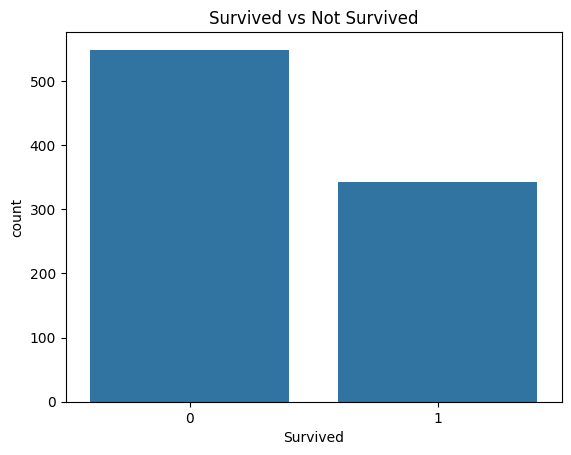

In [ ]:
sns.countplot(data=df, x='Survived')
plt.title("Survived vs Not Survived")
plt.show()


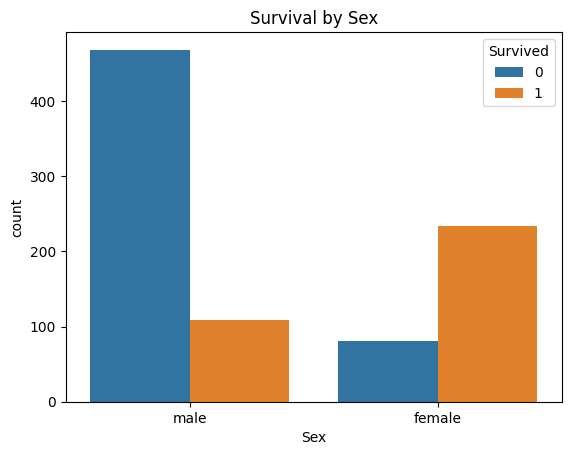

In [ ]:
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title("Survival by Sex")
plt.show()


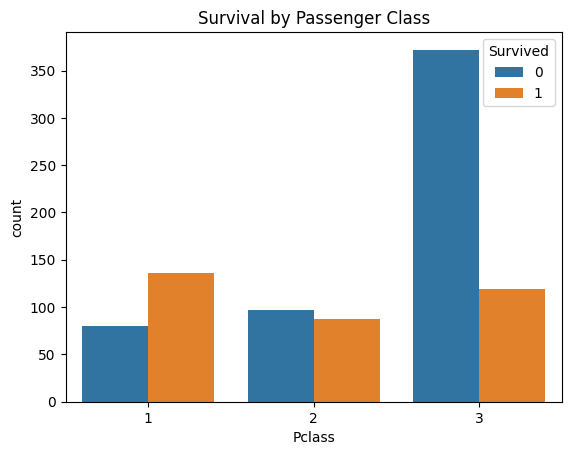

In [ ]:
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title("Survival by Passenger Class")
plt.show()


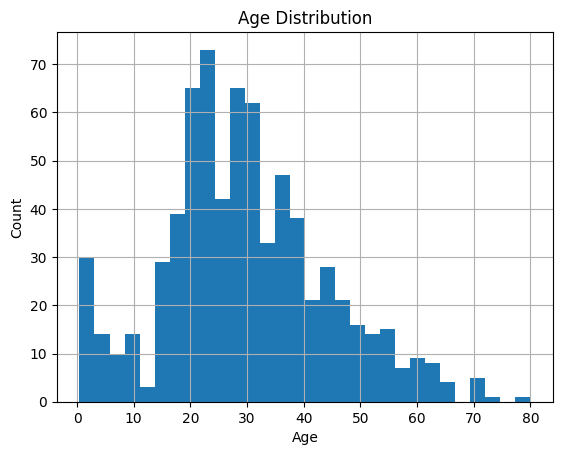

In [ ]:
df['Age'].hist(bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


In [ ]:
df.isna().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:

# 1. Drop columns ONLY if they exist
cols_to_drop = ['Cabin', 'Ticket']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

# 2. Fill Age missing values with median
if df['Age'].isna().sum() > 0:
    df['Age'] = df['Age'].fillna(df['Age'].median())

# 3. Fill Embarked missing with mode (most frequent)
if df['Embarked'].isna().sum() > 0:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 4. Check again
df.isna().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [ ]:
# Create FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create IsAlone (1 = alone, 0 = not alone)
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

df[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head()


,SibSp,Parch,FamilySize,IsAlone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


In [ ]:
target = 'Survived'

features = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'FamilySize',
    'IsAlone'
]

X = df[features]
y = df[target]

X.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,male,22.0,1,0,7.2500,S,2,0
1,1,female,38.0,1,0,71.2833,C,2,0
2,3,female,26.0,0,0,7.9250,S,1,1
3,1,female,35.0,1,0,53.1000,S,2,0
4,3,male,35.0,0,0,8.0500,S,1,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,         # keeps class balance same in train & test
    random_state=42     # reproducible
)

X_train.shape, X_test.shape


((712, 9), (179, 9))

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
# Numerical and categorical columns
num_cols = ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch']
cat_cols = ['Sex', 'Embarked', 'Pclass', 'IsAlone']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]
cv_scores = {}

for c in C_values:
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(max_iter=1000, C=c, random_state=42))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[c] = scores.mean()

cv_scores


{0.01: np.float64(0.7388358120752487),
 0.1: np.float64(0.8034374076627596),
 1: np.float64(0.7964247020585049),
 10: np.float64(0.7950359499655274),
 100: np.float64(0.7950359499655274)}

In [ ]:
best_C = max(cv_scores, key=cv_scores.get)
best_C



0.1

In [ ]:
log_reg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, C=best_C, random_state=42))
])

log_reg_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare', 'FamilySize',
                                                   'SibSp', 'Parch']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'Embarked', 'Pclass',
                                                   'IsAlone'])])),
                ('model',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_test_pred_lr = log_reg_pipeline.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print(confusion_matrix(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr))


Logistic Regression Accuracy: 0.8100558659217877
[[100  10]
 [ 24  45]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       110
           1       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



In [ ]:
from sklearn.metrics import accuracy_score

# Train accuracy
y_train_pred_lr = log_reg_pipeline.predict(X_train)
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)

# Test accuracy
y_test_pred_lr = log_reg_pipeline.predict(X_test)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

print("Logistic Regression Train Accuracy:", train_acc_lr)
print("Logistic Regression Test Accuracy :", test_acc_lr)


Logistic Regression Train Accuracy: 0.8132022471910112
Logistic Regression Test Accuracy : 0.8100558659217877


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare', 'FamilySize',
                                                   'SibSp', 'Parch']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'Embarked', 'Pclass',
                                                   'IsAlone'])])),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=42))])

In [ ]:
y_test_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print(confusion_matrix(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf))


Random Forest Accuracy: 0.8044692737430168
[[104   6]
 [ 29  40]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       110
           1       0.87      0.58      0.70        69

    accuracy                           0.80       179
   macro avg       0.83      0.76      0.78       179
weighted avg       0.82      0.80      0.79       179



In [ ]:
# Train accuracy
y_train_pred_rf = rf_pipeline.predict(X_train)
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)

# Test accuracy
y_test_pred_rf = rf_pipeline.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print("Random Forest Train Accuracy:", train_acc_rf)
print("Random Forest Test Accuracy :", test_acc_rf)


Random Forest Train Accuracy: 0.8553370786516854
Random Forest Test Accuracy : 0.8044692737430168


In [ ]:
rf_model_inner = rf_pipeline.named_steps['model']
feature_names = rf_pipeline.named_steps['preprocess'].get_feature_names_out()

importances = rf_model_inner.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance.head(10)


,Feature,Importance
5,cat__Sex_male,0.415032
1,num__Fare,0.177231
9,cat__Pclass_3,0.109271
0,num__Age,0.102877
2,num__FamilySize,0.061030
7,cat__Embarked_S,0.029131
3,num__SibSp,0.026973
10,cat__IsAlone_1,0.024950
4,num__Parch,0.023134
8,cat__Pclass_2,0.019976


In [ ]:
# Final Conclusion:
# Logistic Regression provides a strong baseline with good generalization.
# Random Forest captures non-linear patterns but offers limited improvement.
# Due to small dataset size, simpler models perform competitively.
# Using a Pipeline ensures no data leakage and reproducibility.


In [ ]:
import joblib
# Save the complete pipeline (preprocessing + model)
joblib.dump(rf_pipeline, "titanic_rf_pipeline.pkl")

print("Model saved successfully")


Model saved successfully
